# Data and libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Import the CSV file containing the data.
# We assume the data file is named 'DeepLearWing.csv' and is in the same directory.
# Adjust the path if necessary.
try:
    df = pd.read_csv('DeepLearWing.csv')
    print("Data file loaded successfully.")
except FileNotFoundError:
    print("Error: 'DeepLearWing.csv' not found.")
    print("Please make sure the file is in the correct directory.")
    sys.exit() # Exit the script if the data file is not found.

Data file loaded successfully.


# Outputing 3 random airfoils and their data

C:\Users\skrze\AppData\Local\Temp\ipykernel_26312\2705530996.py:67: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_plot.legend()


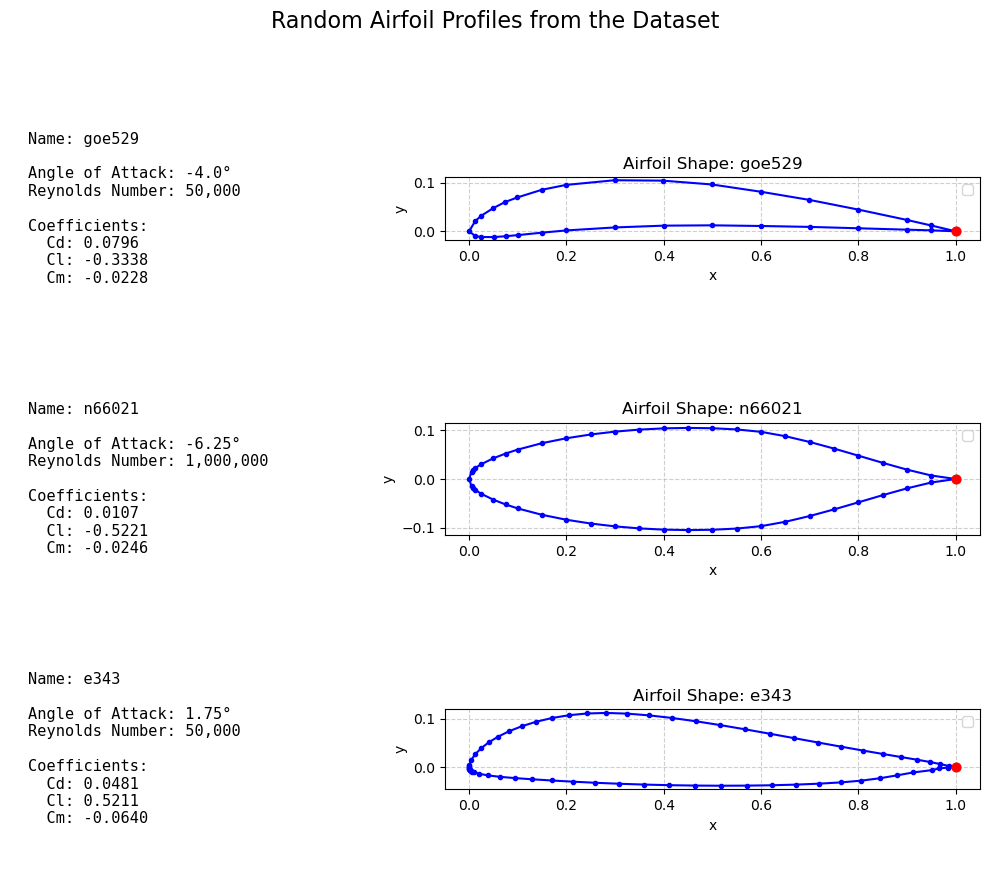

In [32]:
# Select 3 random entries from the airfoil database.
# sample(n=3) draws 3 random rows. random_state ensures reproducibility.
random_airfoils = df.sample(n=3)

# Helper function to parse coordinate strings.
def parse_coords(coord_string):
    """Converts a space-separated string of coordinates into a list of floats."""
    if isinstance(coord_string, str):
        return [float(c) for c in coord_string.strip().split()]
    return []

# Create a table-like visualization using Matplotlib.
# Create a figure with 3 rows and 2 columns.
# gridspec_kw allows setting different widths for the columns.
fig, axes = plt.subplots(3, 2, figsize=(10, 9), 
                         gridspec_kw={'width_ratios': [1, 1.5]})

fig.suptitle('Random Airfoil Profiles from the Dataset', fontsize=16)

# Iterate through the sampled airfoils and plot axes.
for i, (index, row) in enumerate(random_airfoils.iterrows()):
    # --- Left column: Textual information ---
    ax_text = axes[i, 0]
    ax_text.axis('off') # Turn off the axis for the text cell.

    # Collect data for display.
    name = row['name']
    angle = row['angle']
    reynolds = row['reynolds']
    cd = row['cd']
    cl = row['cl']
    cm = row['cm']
    
    # Create the formatted text string.
    info_text = (
        f"Name: {name}\n\n"
        f"Angle of Attack: {angle}°\n"
        f"Reynolds Number: {reynolds:,.0f}\n\n"
        f"Coefficients:\n"
        f"  Cd: {cd:.4f}\n"
        f"  Cl: {cl:.4f}\n"
        f"  Cm: {cm:.4f}"
    )
    
    # Display the text in the cell.
    ax_text.text(0.05, 0.5, info_text, transform=ax_text.transAxes,
                 fontsize=11, verticalalignment='center', family='monospace')

    # --- Right column: Airfoil shape plot ---
    ax_plot = axes[i, 1]

    # Parse the coordinates.
    x_coords = parse_coords(row['x_coords'])
    y_coords = parse_coords(row['y_coords'])
    
    # Plot the airfoil shape.
    ax_plot.plot(x_coords, y_coords, marker='o', markersize=3, linestyle='-', color='b')
    ax_plot.scatter([x_coords[0]], [y_coords[0]], color='red', s=40, zorder=5,) # Highlight the start point.
    
    # Configure the plot settings.
    ax_plot.set_title(f'Airfoil Shape: {name}')
    ax_plot.set_xlabel('x')
    ax_plot.set_ylabel('y')
    ax_plot.grid(True, linestyle='--', alpha=0.6)
    # set_aspect('equal') is crucial to maintain the airfoil's proportions.
    ax_plot.set_aspect('equal', adjustable='box')
    ax_plot.legend()

# Adjust the layout to prevent elements from overlapping.
# rect leaves space for the main title.
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

# Data Preprocessing for the LSTM Model

In [34]:
print("\n--- Starting Data Preprocessing for LSTM Model ---")

# Parse all coordinate strings into lists of floats.
df['x_coords_list'] = df['x_coords'].apply(parse_coords)
df['y_coords_list'] = df['y_coords'].apply(parse_coords)

# Combine x and y coordinates into sequences of points.
df['points'] = [list(zip(x, y)) for x, y in zip(df['x_coords_list'], df['y_coords_list'])]

# Define features and targets.
features_scalar = ['angle', 'reynolds']
features_sequence = 'points'
targets = ['cl', 'cd', 'cm']

# Split data by unique airfoil names for robust validation.
# airfoil_names = df['name'].unique()
# train_names, test_names = train_test_split(airfoil_names, test_size=0.3, random_state=42)
# val_names, test_names = train_test_split(test_names, test_size=0.5, random_state=42)

# Temporal settings for faster testing of code
airfoil_names = df['name'].unique()
subset_names, _ = train_test_split(airfoil_names, train_size=0.02, random_state=42)
train_names, test_names = train_test_split(subset_names, test_size=0.3, random_state=42)
val_names, test_names = train_test_split(test_names, test_size=0.5, random_state=42)


train_df = df[df['name'].isin(train_names)]
val_df = df[df['name'].isin(val_names)]
test_df = df[df['name'].isin(test_names)]

print(f"Data split into: \n- Train: {len(train_df)} samples ({len(train_names)} unique airfoils)\n- Validation: {len(val_df)} samples ({len(val_names)} unique airfoils)\n- Test: {len(test_df)} samples ({len(test_names)} unique airfoils)")

# Normalize scalar features and targets using MinMaxScaler.
# Scalers are fitted ONLY on the training data to prevent data leakage.
scalar_feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform training data.
train_df[features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
train_df[targets] = target_scaler.fit_transform(train_df[targets])

# Transform validation and test data using the fitted scalers.
val_df[features_scalar] = scalar_feature_scaler.transform(val_df[features_scalar])
val_df[targets] = target_scaler.transform(val_df[targets])
test_df[features_scalar] = scalar_feature_scaler.transform(test_df[features_scalar])
test_df[targets] = target_scaler.transform(test_df[targets])

print("Scalar features and targets have been normalized.")


--- Starting Data Preprocessing for LSTM Model ---
Data split into: 
- Train: 11117 samples (22 unique airfoils)
- Validation: 2742 samples (5 unique airfoils)
- Test: 2475 samples (5 unique airfoils)
Scalar features and targets have been normalized.


C:\Users\skrze\AppData\Local\Temp\ipykernel_26312\944245271.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[features_scalar] = scalar_feature_scaler.fit_transform(train_df[features_scalar])
C:\Users\skrze\AppData\Local\Temp\ipykernel_26312\944245271.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[targets] = target_scaler.fit_transform(train_df[targets])
C:\Users\skrze\AppData\Local\Temp\ipykernel_26312\944245271.py:43: SettingWithCopyWarning: 
A value is trying to be set on a cop

# PyTorch Dataset and DataLoader for LSTM

In [ ]:
class AirfoilDataset(Dataset):
    """Custom PyTorch Dataset for airfoil data."""
    def __init__(self, dataframe):
        self.sequences = [torch.tensor(seq, dtype=torch.float32) for seq in dataframe[features_sequence].values]
        self.other_features = torch.tensor(dataframe[features_scalar].values, dtype=torch.float32)
        self.targets = torch.tensor(dataframe[targets].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.other_features[idx], self.targets[idx]

def collate_fn(batch):
    """
    Custom collate function to handle variable length sequences.
    It pads sequences to the max length in a batch.
    """
    sequences, other_features, targets = zip(*batch)
    
    # Get the length of each sequence before padding.
    sequence_lengths = torch.tensor([len(seq) for seq in sequences])
    
    # Pad sequences to the length of the longest sequence in the batch.
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)
    
    # Stack other features and targets into tensors.
    other_features_tensor = torch.stack(other_features)
    targets_tensor = torch.stack(targets)
    
    return padded_sequences, sequence_lengths, other_features_tensor, targets_tensor

# Create Datasets
train_dataset = AirfoilDataset(train_df)
val_dataset = AirfoilDataset(val_df)
test_dataset = AirfoilDataset(test_df)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("PyTorch Datasets and DataLoaders created.")

PyTorch Datasets and DataLoaders created.


# LSTM model

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AirfoilLSTMRegressor(nn.Module):
    def __init__(self, point_dim=2, lstm_hidden_dim=128, num_lstm_layers=2, 
                 fc_hidden_dim=64, output_dim=3, other_features_dim=2, dropout_prob=0.2):
        super(AirfoilLSTMRegressor, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=point_dim,
            hidden_size=lstm_hidden_dim,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        self.fc1 = nn.Linear(lstm_hidden_dim + other_features_dim, fc_hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(fc_hidden_dim, output_dim)

    def forward(self, sequence_data, sequence_lengths, other_features):
        packed_input = pack_padded_sequence(
            sequence_data, 
            sequence_lengths.cpu(),
            batch_first=True, 
            enforce_sorted=False
        )
        
        packed_lstm_out, (h_n, _) = self.lstm(packed_input)
        shape_representation = h_n[-1,:,:]
        combined_features = torch.cat((shape_representation, other_features), dim=1)
        x = self.fc1(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        predictions = self.fc2(x)
        
        return predictions


# Model Training

In [35]:
# Setup device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n--- Starting Model Training on {device} ---")

# Instantiate the model
model = AirfoilLSTMRegressor(
    point_dim=2,
    lstm_hidden_dim=128,
    num_lstm_layers=2,
    fc_hidden_dim=64,
    output_dim=3,
    other_features_dim=2,
    dropout_prob=0.3
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() # Mean Squared Error is suitable for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
NUM_EPOCHS = 2 # For demonstration; more epochs needed for real results
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    for sequences, lengths, others, targets_batch in train_loader:
        # Move data to the selected device
        sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)

        # Forward pass
        predictions = model(sequences, lengths, others)
        loss = criterion(predictions, targets_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for sequences, lengths, others, targets_batch in val_loader:
            sequences, lengths, others, targets_batch = sequences.to(device), lengths.to(device), others.to(device), targets_batch.to(device)
            
            predictions = model(sequences, lengths, others)
            loss = criterion(predictions, targets_batch)
            running_val_loss += loss.item()
            
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

print("\nTraining finished.")


--- Starting Model Training on cpu ---


KeyboardInterrupt: 

# Showing training and validation loss based on LSTM model

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()